In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import os


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
scz_path = 'clean_data/SCZ/schaefer1000'
controls_path = 'clean_data/controls/schaefer1000'

# Log Model on Gradients

## Get train & test data

In [3]:
scz_subjects = np.loadtxt('COBRE_SCZ_subjects.txt', dtype = str)
control_subjects = np.loadtxt('COBRE_controls_subjects.txt', dtype = str)

In [5]:
# train sample

scz_subjects_train = np.loadtxt('COBRE_SCZ_subjects.txt', dtype = str)[:60]
control_subjects_train = np.loadtxt('COBRE_controls_subjects.txt', dtype = str)[:60]
subjects_train = np.concatenate((control_subjects_train, scz_subjects_train))

group_train = np.zeros(len(scz_subjects_train) + len(control_subjects_train))
group_train[:len(scz_subjects_train)] = 1
group_train = group_train.astype(bool)
data_train = np.stack((subjects_train, group_train))

In [6]:
data_train.shape

(2, 120)

In [7]:
# test sample 

scz_subjects_test = np.loadtxt('COBRE_SCZ_subjects.txt', dtype = str)[60:]
control_subjects_test = np.loadtxt('COBRE_controls_subjects.txt', dtype = str)[60:]
subjects_test = np.concatenate((scz_subjects_test, control_subjects_test))

group_test = np.zeros(len(scz_subjects_test) + len(control_subjects_test))
group_test[:len(scz_subjects_test)] = 1
group_test = group_test.astype(bool)
data_test = np.stack((subjects_test, group_test))

In [8]:
data_test.shape

(2, 44)

In [9]:
subject_df_train = pd.DataFrame(data_train.T, columns = ['Subject', 'Group'])
subject_df_test = pd.DataFrame(data_test.T, columns = ['Subject', 'Group'])

In [10]:
# train grads
scz_grads_train = []
for subject in scz_subjects_train:
    grads = np.load(f'{scz_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')
    scz_grads_train.append(grads)
scz_grads_train = np.stack(scz_grads_train)

control_grads_train = []
for subject in control_subjects_train:
    grads = np.load(f'{controls_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')
    control_grads_train.append(grads)
control_grads_train = np.stack(control_grads_train)


In [11]:
# test grads
scz_grads_test = []
for subject in scz_subjects_test:
    grads = np.load(f'{scz_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')
    scz_grads_test.append(grads)
scz_grads_test = np.stack(scz_grads_test)

control_grads_test = []
for subject in control_subjects_test:
    grads = np.load(f'{controls_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')
    control_grads_test.append(grads)
control_grads_test = np.stack(control_grads_test)

In [12]:
train_grads = np.row_stack((scz_grads_train, control_grads_train))
test_grads = np.row_stack((scz_grads_test, control_grads_test))

In [13]:
train_grads.shape
test_grads.shape

(120, 1000, 10)

(44, 1000, 10)

## Prepare Input

In [14]:
X_train_grads = train_grads[:, :, :6].reshape(train_grads.shape[0], -1)
y_train = subject_df_train['Group'].values

X_test_grads = test_grads[:, :, :6].reshape(test_grads.shape[0], -1)
y_test = subject_df_test['Group'].values


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train= le.fit_transform(y_train)
y_test= le.fit_transform(y_test)


## Train & Test Model on Gradients

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

perf_df_grads = pd.DataFrame(columns = ['N_grads', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC', 'Deviance'])

acc_list = []
prec_list = []
rec_list = []
f1_list = []
roc_auc_list = []
deviance_list = []

for n_grads in range(1, 11):
    X_train_grads = train_grads[:, :, :n_grads].reshape(train_grads.shape[0], -1)
    X_test_grads = test_grads[:, :, :n_grads].reshape(test_grads.shape[0], -1)

    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_train_grads, y_train)

    y_prob = clf.predict_proba(X_test_grads)
    y_pred = clf.predict(X_test_grads)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1)
    rec = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_prob[:, 1])

    log_likelihood_model = np.sum(y_test * np.log(y_prob[:, 1]) + (1 - y_test) * np.log(1 - y_prob[:, 1]))
    log_likelihood_saturated = np.sum(y_test * np.log(np.mean(y_test)) + (1 - y_test) * np.log(1 - np.mean(y_test)))
    deviance = -2 * (log_likelihood_model - log_likelihood_saturated)

    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    deviance_list.append(deviance)

perf_df_grads['N_grads'] = np.arange(1, 11)
perf_df_grads['Accuracy'] = acc_list
perf_df_grads['Precision'] = prec_list
perf_df_grads['Recall'] = rec_list
perf_df_grads['F1'] = f1_list
perf_df_grads['ROC_AUC'] = roc_auc_list
perf_df_grads['Deviance'] = deviance_list



LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

In [16]:
perf_df_grads

,N_grads,Accuracy,Precision,Recall,F1,ROC_AUC,Deviance
0,1,0.568182,0.392857,0.846154,0.536585,0.746898,65.063652
1,2,0.613636,0.423077,0.846154,0.564103,0.761787,42.160607
2,3,0.636364,0.434783,0.769231,0.555556,0.719603,46.007221
3,4,0.613636,0.416667,0.769231,0.540541,0.741935,46.019495
4,5,0.613636,0.416667,0.769231,0.540541,0.756824,41.939504
5,6,0.659091,0.458333,0.846154,0.594595,0.779156,39.102334
6,7,0.636364,0.440000,0.846154,0.578947,0.769231,39.975028
7,8,0.613636,0.423077,0.846154,0.564103,0.779156,36.247485
8,9,0.590909,0.400000,0.769231,0.526316,0.771712,34.725258
9,10,0.613636,0.423077,0.846154,0.564103,0.776675,34.621426


<Axes: title={'center': 'Performance of Logistic Regression on 1-10 Gradients'}, xlabel='N_grads'>

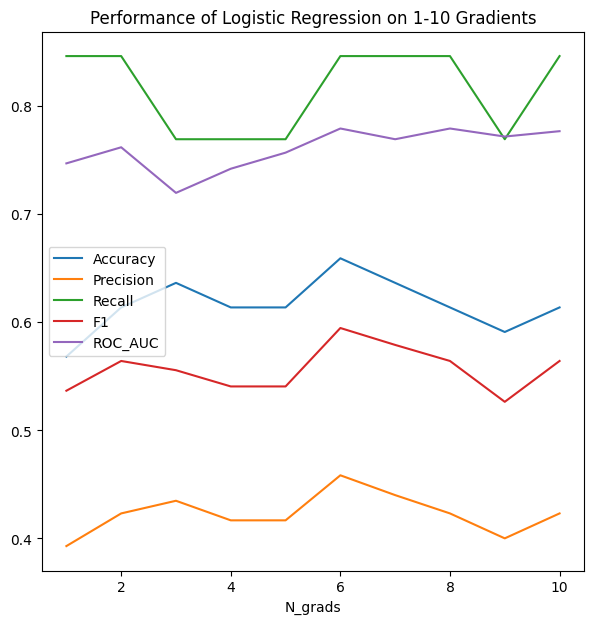

In [17]:
perf_df_grads.plot(x = 'N_grads', y = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'], figsize = (7, 7), title = 'Performance of Logistic Regression on 1-10 Gradients')

# Log Model on Dispersion

In [18]:
# Compute dispersion

n_neighbours_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]

n_grads = 6
for n_neighbours in n_neighbours_list:
    for subject in scz_subjects:
        gradients = np.load(f'{scz_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')[:, :n_grads]
        hcp_ngbrs = NearestNeighbors(n_neighbors=n_neighbours, algorithm='brute').fit(gradients)
        distances, indices = hcp_ngbrs.kneighbors(gradients)
        subj_disp = distances.mean(axis = 1)
        np.save(f'{scz_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy', subj_disp)

    for subject in control_subjects:
        gradients = np.load(f'{controls_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')[:, :n_grads]
        hcp_ngbrs = NearestNeighbors(n_neighbors=n_neighbours, algorithm='brute').fit(gradients)
        distances, indices = hcp_ngbrs.kneighbors(gradients)
        subj_disp = distances.mean(axis = 1)
        np.save(f'{controls_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy', subj_disp)

## Prepare Disp Input

In [19]:
# load train & test dispersion in dicts

disp_dict_train = {}
disp_dict_test = {}

for n_neighbours in n_neighbours_list:
    disp_train = []
    for subject in scz_subjects_train:
        disp = np.load(f'{scz_path}/sub-{subject}/func/disp_6_{n_neighbours}n_{subject}_schaefer1000.npy')
        disp_train.append(disp)
    for subject in control_subjects_train:
        disp = np.load(f'{controls_path}/sub-{subject}/func/disp_6_{n_neighbours}n_{subject}_schaefer1000.npy')
        disp_train.append(disp)

    disp_train = np.stack(disp_train)
    disp_dict_train[n_neighbours] = disp_train

    disp_test = []
    for subject in scz_subjects_test:
        disp = np.load(f'{scz_path}/sub-{subject}/func/disp_6_{n_neighbours}n_{subject}_schaefer1000.npy')
        disp_test.append(disp)
    for subject in control_subjects_test:
        disp = np.load(f'{controls_path}/sub-{subject}/func/disp_6_{n_neighbours}n_{subject}_schaefer1000.npy')
        disp_test.append(disp)

    disp_test = np.stack(disp_test)
    disp_dict_test[n_neighbours] = disp_test
    


## Train & Test Model on Dispersion

In [20]:
perf_df_disp = pd.DataFrame(columns = ['N_neighbours', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC', 'Deviance'])

acc_list = []
prec_list = []
rec_list = []
f1_list = []
roc_auc_list = []
deviance_list = []

for n_neighbours in n_neighbours_list:
    X_train_disp = disp_dict_train[n_neighbours]
    X_test_disp = disp_dict_test[n_neighbours]

    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_train_disp, y_train)

    y_prob = clf.predict_proba(X_test_disp)
    y_pred = clf.predict(X_test_disp)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1)
    rec = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_prob[:, 1])

    log_likelihood_model = np.sum(y_test * np.log(y_prob[:, 1]) + (1 - y_test) * np.log(1 - y_prob[:, 1]))
    log_likelihood_saturated = np.sum(y_test * np.log(np.mean(y_test)) + (1 - y_test) * np.log(1 - np.mean(y_test)))
    deviance = -2 * (log_likelihood_model - log_likelihood_saturated)

    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    deviance_list.append(deviance)

perf_df_disp['N_neighbours'] = n_neighbours_list
perf_df_disp['Accuracy'] = acc_list
perf_df_disp['Precision'] = prec_list
perf_df_disp['Recall'] = rec_list
perf_df_disp['F1'] = f1_list
perf_df_disp['ROC_AUC'] = roc_auc_list
perf_df_disp['Deviance'] = deviance_list



LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

In [21]:
perf_df_disp

,N_neighbours,Accuracy,Precision,Recall,F1,ROC_AUC,Deviance
0,5,0.681818,0.476190,0.769231,0.588235,0.672457,12.430689
1,10,0.704545,0.500000,0.692308,0.580645,0.684864,11.128978
2,15,0.750000,0.562500,0.692308,0.620690,0.677419,10.087393
3,20,0.727273,0.529412,0.692308,0.600000,0.667494,8.900435
4,25,0.727273,0.533333,0.615385,0.571429,0.669975,7.784036
5,30,0.750000,0.571429,0.615385,0.592593,0.669975,6.677511
6,35,0.772727,0.615385,0.615385,0.615385,0.657568,5.632642
7,40,0.795455,0.666667,0.615385,0.640000,0.660050,4.445461
8,45,0.795455,0.666667,0.615385,0.640000,0.679901,3.256509
9,50,0.795455,0.666667,0.615385,0.640000,0.692308,2.139895


<Axes: title={'center': 'Performance of Logistic Regression on Dispersion'}, xlabel='N_neighbours'>

([<matplotlib.axis.XTick at 0x7ff2adbe1640>,
 [Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20'),
  Text(25, 0, '25'),
  Text(30, 0, '30'),
  Text(35, 0, '35'),
  Text(40, 0, '40'),
  Text(45, 0, '45'),
  Text(50, 0, '50'),
  Text(55, 0, '55'),
  Text(60, 0, '60'),
  Text(65, 0, '65'),
  Text(70, 0, '70'),
  Text(75, 0, '75'),
  Text(80, 0, '80'),
  Text(85, 0, '85'),
  Text(90, 0, '90'),
  Text(95, 0, '95'),
  Text(100, 0, '100'),
  Text(105, 0, '105'),
  Text(110, 0, '110'),
  Text(115, 0, '115'),
  Text(120, 0, '120')])

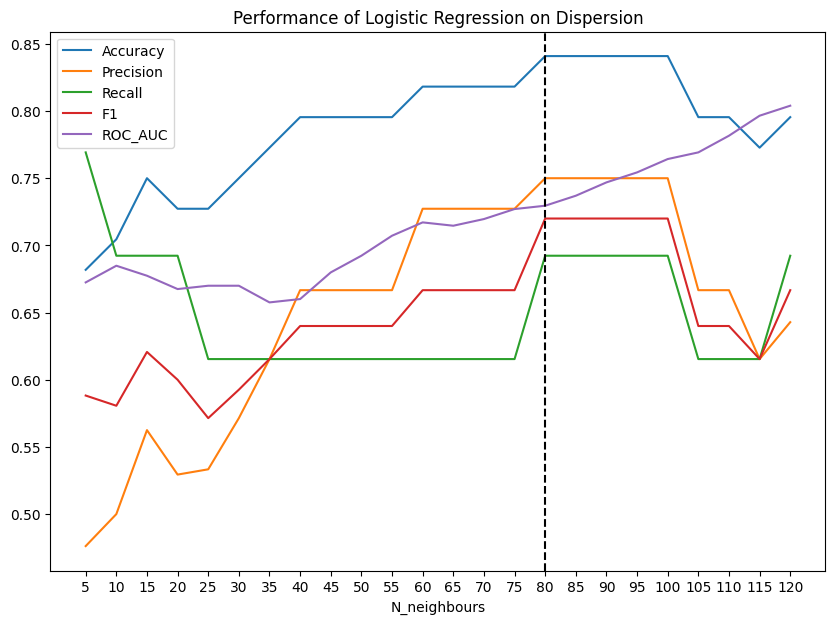

In [22]:
from matplotlib import pyplot as plt

perf_df_disp.plot(x = 'N_neighbours', y = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'], figsize = (10, 7), title = 'Performance of Logistic Regression on Dispersion')
# draw a vertical line where accuracy is maximum
#disply every level of n_neighbours on the x-axis
plt.xticks(perf_df_disp['N_neighbours'])
plt.axvline(perf_df_disp['N_neighbours'][perf_df_disp['Accuracy'].idxmax()], color = 'k', linestyle = '--')


## Permutation test to identify sig. regions

In [23]:
X_train_disp[:, 1].shape

(120,)

In [24]:
X_train_disp = disp_dict_train[80]
X_test_disp = disp_dict_test[80]

In [25]:
from tqdm import tqdm

def perm_test_logreg(X_train, X_test, y_train, y_test, n_permutations=1000):
    # Initialize empty arrays to store beta coefficients and p-values for each region
    beta_coefficients = np.zeros(X_train.shape[1])
    p_values = np.zeros(X_train.shape[1])
    
    # Fit a logistic regression model to the training data
    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_train, y_train)

    # Compute the beta coefficients for the logistic regression model
    beta_coefficients = clf.coef_[0]

    # Compute the p-values for the beta coefficients using a permutation test
    np.random.seed(0)
    for i in tqdm(range(X_train.shape[1]), desc="Computing p-values"):
        permuted_feature = np.random.permutation(X_train[:, i])
        permuted_X_train = np.copy(X_train)
        permuted_X_train[:, i] = permuted_feature

        clf_permuted = LogisticRegression(max_iter=10000)
        clf_permuted.fit(permuted_X_train, y_train)

        beta_coefficients_permuted = clf_permuted.coef_[0][i]
        beta_diff = beta_coefficients_permuted - beta_coefficients[i]
        
        permuted_beta_diffs = np.zeros(n_permutations)
        for j in range(n_permutations):
            permuted_y_train = np.random.permutation(y_train)
            clf_permuted_y = LogisticRegression(max_iter=10000)
            clf_permuted_y.fit(permuted_X_train, permuted_y_train)
            permuted_beta_coefficients = clf_permuted_y.coef_[0][i]
            permuted_beta_diffs[j] = permuted_beta_coefficients - beta_coefficients[i]
        
        p_values[i] = np.sum(np.abs(permuted_beta_diffs) >= np.abs(beta_diff)) / n_permutations
    
    # Create a dataframe to store the beta coefficients and p-values for each region
    regions = [i for i in range(X_train.shape[1])]
    data = {'Region': regions, 'Beta Coefficient': beta_coefficients, 'P-value': p_values}
    df = pd.DataFrame(data)
    
    return df

In [113]:
results = perm_test_logreg(X_train_disp, X_test_disp, y_train, y_test)

Computing p-values:   0%|          | 1/1000 [01:08<19:07:44, 68.93s/it]


KeyboardInterrupt: 

In [53]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from permutation_test import permutation_test

def perm_test_logreg(X_train, y_train, n_permutations=1000):
    # Initialize empty arrays to store beta coefficients and p-values for each region
    beta_coefficients = np.zeros(X_train.shape[1])
    p_values = np.zeros(X_train.shape[1])

    # Fit a logistic regression model to the training data
    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_train, y_train)

    # Compute the beta coefficients for the logistic regression model
    beta_coefficients = clf.coef_[0]

    # Compute the p-values for the beta coefficients using a permutation test
    with Pool(processes=cpu_count()) as pool:
        results = [pool.apply_async(permutation_test, args=(X_train, y_train, beta_coefficients, i, n_permutations)) for i in range(X_train.shape[1])]
        p_values = [r.get() for r in results]

    # Create a dataframe to store the beta coefficients and p-values for each region
    regions = [i for i in range(X_train.shape[1])]
    data = {'Region': regions, 'Beta Coefficient': beta_coefficients, 'P-value': p_values}
    df = pd.DataFrame(data)

    return df



In [49]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

def permutation_test(X_train, y_train, beta_coefficients, i, n_permutations):
    permuted_feature = np.random.permutation(X_train[:, i])
    permuted_X_train = np.copy(X_train)
    permuted_X_train[:, i] = permuted_feature

    clf_permuted = LogisticRegression(max_iter=10000)
    clf_permuted.fit(permuted_X_train, y_train)

    beta_coefficients_permuted = clf_permuted.coef_[0][i]
    beta_diff = beta_coefficients_permuted - beta_coefficients[i]

    permuted_beta_diffs = np.zeros(n_permutations)
    for j in range(n_permutations):
        permuted_y_train = np.random.permutation(y_train)
        clf_permuted_y = LogisticRegression(max_iter=10000)
        clf_permuted_y.fit(permuted_X_train, permuted_y_train)
        permuted_beta_coefficients = clf_permuted_y.coef_[0][i]
        permuted_beta_diffs[j] = permuted_beta_coefficients - beta_coefficients[i]

    p_value = np.sum(np.abs(permuted_beta_diffs) >= np.abs(beta_diff)) / n_permutations

    return p_value

def perm_test_logreg(X_train, X_test, y_train, y_test, n_permutations=1000):
    # Initialize empty arrays to store beta coefficients and p-values for each region
    beta_coefficients = np.zeros(X_train.shape[1])
    p_values = np.zeros(X_train.shape[1])

    # Fit a logistic regression model to the training data
    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_train, y_train)

    # Compute the beta coefficients for the logistic regression model
    beta_coefficients = clf.coef_[0]

    # Compute the p-values for the beta coefficients using a permutation test
    with Pool(processes=cpu_count()) as pool:
        results = []
        for i in range(X_train.shape[1]):
            results.append(pool.apply_async(permutation_test, args=(X_train, y_train, beta_coefficients, i, n_permutations)))

        for i, r in enumerate(tqdm(results)):
            p_values[i] = r.get()

    # Create a dataframe to store the beta coefficients and p-values for each region
    regions = [i for i in range(X_train.shape[1])]
    data = {'Region': regions, 'Beta Coefficient': beta_coefficients, 'P-value': p_values}
    df = pd.DataFrame(data)

    return df


In [54]:
results = perm_test_logreg(X_train = X_train_disp, y_train = y_train, n_permutations=1000)

KeyboardInterrupt: 

In [ ]:
results

,Region,Beta Coefficient,P-value
0,0,-0.025670,<multiprocessing.pool.ApplyResult object at 0x...
1,1,-0.100791,<multiprocessing.pool.ApplyResult object at 0x...
2,2,-0.292214,<multiprocessing.pool.ApplyResult object at 0x...
3,3,-0.094033,<multiprocessing.pool.ApplyResult object at 0x...
4,4,-0.015198,<multiprocessing.pool.ApplyResult object at 0x...
...,...,...,...
995,995,0.071669,<multiprocessing.pool.ApplyResult object at 0x...
996,996,-0.037857,<multiprocessing.pool.ApplyResult object at 0x...
997,997,-0.029367,<multiprocessing.pool.ApplyResult object at 0x...
998,998,0.004372,<multiprocessing.pool.ApplyResult object at 0x...
